# Functions


In [213]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
from itertools import product
from mpl_toolkits.mplot3d import Axes3D  # 3D projection
import numpy as np
import os
import time

In [214]:
# parameters
dt = 0.1  # time step
t_end = 30  # total time
t0 = 0  # initial time
N = int(t_end / dt)  # number of time steps
M = 10
device = "cuda" if torch.cuda.is_available() else "cpu"

## VDP System

In [215]:
# ----------------------------
# Van der Pol System (device-safe)
# ----------------------------
def vdp(y, mu=1.0):
    return torch.stack([
        y[1],
        mu * (1 - y[0]**2) * y[1] - y[0]
    ]).to(y)

# ----------------------------
# General RK Integrator (Explicit & Implicit)
# ----------------------------
def rk_apply(butcher, x, dt, f, max_iter=10, tol=1e-8):
    A = torch.tensor(butcher['A'], dtype=x.dtype, device=x.device)
    b = torch.tensor(butcher['b'], dtype=x.dtype, device=x.device)

    s = len(b)
    d = x.shape[0]
    k = torch.zeros((s, d), dtype=x.dtype, device=x.device)

    for i in range(s):
        k_i = k[i].clone()


        #The is a banach iterator and I should try a newton method instead
        def G(ki_guess):
            weighted_sum = sum(A[i, j] * (ki_guess if j == i else k[j]) for j in range(s))
            return f(x + dt * weighted_sum)

        for _ in range(max_iter):
            ki_new = G(k_i)
            if torch.norm(ki_new - k_i) < tol:
                break
            k_i = ki_new

        k[i] = k_i

    x_next = x + dt * torch.sum(b.view(-1, 1) * k, dim=0)
    return k, x_next

# ----------------------------
# Training Data Generation
# ----------------------------
def generate_training_data(func, y0, t0, t_end, dt=dt, butcher=None, mu=1.0, M = M, device="cpu"):
    """
    Integrate using rk_apply and collect (x_n, k_n) pairs for NN training.
    """

    if butcher is None:
        raise ValueError("Butcher tableau must be provided.")
    
    N = int((t_end - t0) / dt) + 1
    
    x = y0.to(device)
    d = x.shape[0]
    s = len(butcher['b'])

    X = torch.zeros((N, d), dtype=torch.float32, device=device)
    K = torch.zeros((N, s, d), dtype=torch.float32, device=device)

    for n in range(N):
        X[n] = x
        k, x_next = rk_apply(butcher, x, dt/M, lambda y: func(y, mu=mu))
        for i in range(M-1):
            k, x_next = rk_apply(butcher, x_next, dt/M, lambda y: func(y, mu=mu))
        K[n] = k
        x = x_next

    return X, K

def generate_training_data_all_ics(func, y0s, t0, t_end, dt, butcher, mu=1.0, M = M, device="cpu"):
    data = []
    for y0 in y0s:
        X, K = generate_training_data(func, y0, t0, t_end, dt, butcher, mu=mu, M=M, device=device)
        data.append((X, K))

    X_all = torch.cat([pair[0] for pair in data], dim=0)
    K_all = torch.cat([pair[1] for pair in data], dim=0)
    return X_all, K_all

## LHCb system

In [ ]:
from Classes.magnetic_field import Quadratic_Field, LHCb_Field
from Classes.particle import  particle_state
from Classes.Simulators import RK4_sim_dz



# ----------------------------
# LHCb system (device-safe)
# ----------------------------
def LHCbBfield(state):
	"""Compute the derivative of the state vector using the Lorentz force"""

	field = 'Data/twodip.rtf'
	B = LHCb_Field(field).interpolated_field(state[0], state[1], state[2])

	# print(f' B field vector values: {B} | B field strength : {self.field.field_strength(B)}')
	dx = state[2]
	dy = state[3]
	q_over_p = state[4]
	dtx = q_over_p * np.sqrt(1 + dx**2 + dy**2) * (dy*(dx*B[0] + B[2]) - (1 + dx**2)*B[1])
	dty = -q_over_p * np.sqrt(1 + dx**2 + dy**2) * (dx*(dy*B[1] + B[2]) - (1 + dy**2)*B[0])
	return  dx, dy, dtx, dty, 0



## RK Overheads

In [ ]:
# ----------------------------
# General RK Integrator (Explicit & Implicit)
# ----------------------------
def rk_apply(butcher, x, dt, f, max_iter=10, tol=1e-8):
    A = torch.tensor(butcher['A'], dtype=x.dtype, device=x.device)
    b = torch.tensor(butcher['b'], dtype=x.dtype, device=x.device)

    s = len(b)
    d = x.shape[0]
    k = torch.zeros((s, d), dtype=x.dtype, device=x.device)

    for i in range(s):
        k_i = k[i].clone()


        #The is a banach iterator and I should try a newton method instead
        def G(ki_guess):
            weighted_sum = sum(A[i, j] * (ki_guess if j == i else k[j]) for j in range(s))
            return f(x + dt * weighted_sum)

        for _ in range(max_iter):
            ki_new = G(k_i)
            if torch.norm(ki_new - k_i) < tol:
                break
            k_i = ki_new

        k[i] = k_i

    x_next = x + dt * torch.sum(b.view(-1, 1) * k, dim=0)
    return k, x_next

# ----------------------------
# Training Data Generation
# ----------------------------
def generate_training_data(func, y0, t0, t_end, dt=dt, butcher=None, mu=1.0, M = M, device="cpu"):
    """
    Integrate using rk_apply and collect (x_n, k_n) pairs for NN training.
    """

    if butcher is None:
        raise ValueError("Butcher tableau must be provided.")
    
    N = int((t_end - t0) / dt) + 1
    
    x = y0.to(device)
    d = x.shape[0]
    s = len(butcher['b'])

    X = torch.zeros((N, d), dtype=torch.float32, device=device)
    K = torch.zeros((N, s, d), dtype=torch.float32, device=device)

    for n in range(N):
        X[n] = x
        k, x_next = rk_apply(butcher, x, dt/M, lambda y: func(y, mu=mu))
        for i in range(M-1):
            k, x_next = rk_apply(butcher, x_next, dt/M, lambda y: func(y, mu=mu))
        K[n] = k
        x = x_next

    return X, K

def generate_training_data_all_ics(func, y0s, t0, t_end, dt, butcher, mu=1.0, M = M, device="cpu"):
    data = []
    for y0 in y0s:
        X, K = generate_training_data(func, y0, t0, t_end, dt, butcher, mu=mu, M=M, device=device)
        data.append((X, K))

    X_all = torch.cat([pair[0] for pair in data], dim=0)
    K_all = torch.cat([pair[1] for pair in data], dim=0)
    return X_all, K_all

## NN Class

In [216]:
import os

# ----------------------------
# Neural Network RK Stage Predictor
# ----------------------------
class NeuralRK(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=64, num_layers=3, output_dim=2, butcher=None):
        super().__init__()
        if butcher is None:
            butcher = {
                'A': [
                    [0.0, 0.0, 0.0, 0.0],
                    [0.5, 0.0, 0.0, 0.0],
                    [0.0, 0.5, 0.0, 0.0],
                    [0.0, 0.0, 1.0, 0.0]
                ],
                'b': [1/6, 1/3, 1/3, 1/6],
                'c': [0.0, 0.5, 0.5, 1.0]
            }
        self.butcher = butcher
        self.s = len(butcher['b'])
        self.dt = dt
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        layers = [nn.Linear(input_dim, hidden_dim), nn.Tanh()]
        for _ in range(num_layers - 1):
            layers += [nn.Linear(hidden_dim, hidden_dim), nn.Tanh()]
        layers += [nn.Linear(hidden_dim, self.s * output_dim)]
        self.net = nn.Sequential(*layers)

    def name_model(self, system_name, scheme):
        if system_name == "LHCb":
            save_dir = os.path.join("Results", "LHCb", "Models")
        elif system_name == "VDP":
            save_dir = os.path.join("Results", "VDP", "Models")
        else:
            raise ValueError("Unknown system_name: " + system_name)

        os.makedirs(save_dir, exist_ok=True)

        model_info = {
            "num_layers": self.num_layers,
            "hidden_dim": self.hidden_dim,
            "system_name": system_name
        }
        filename = f"NeuralRK_{system_name}_hd{self.hidden_dim}_layers{self.num_layers}_dt{self.dt}_{scheme}.pt"
        return os.path.join(save_dir, filename)

    def forward(self, x):
        batch_size = x.shape[0]
        out = self.net(x)
        return out.view(batch_size, self.s, self.output_dim)

    def loss_fn(self, x, k_true):
        k_pred = self.forward(x)
        return F.mse_loss(k_pred, k_true)
    
    def save_model(self, system_name, scheme):
        if system_name == "LHCb":
            save_dir = os.path.join("Results", "LHCb", "Models")
        elif system_name == "VDP":
            save_dir = os.path.join("Results", "VDP", "Models")
        else:
            raise ValueError("Unknown system_name: " + system_name)

        os.makedirs(save_dir, exist_ok=True)

        model_info = {
            "input_dim": self.net[0].in_features,
            "hidden_dim": self.hidden_dim,
            "output_dim": self.output_dim,
            "num_layers": self.num_layers,
            "dt": self.dt,
            "s": self.s,
            "system_name": system_name
        }

        filename = f"NeuralRK_{system_name}_hd{self.hidden_dim}_layers{self.num_layers}_dt{self.dt}_{scheme}.pt"
        path = os.path.join(save_dir, filename)

        torch.save(
            {
                "model_state_dict": self.state_dict(),
                "model_info": model_info
            },
            path
        )
        print(f"Model saved to {path}")

    def does_model_exist(self, system_name, scheme):
        if system_name == "LHCb":
            save_dir = os.path.join("Results", "LHCb", "Models")
        elif system_name == "VDP":
            save_dir = os.path.join("Results", "VDP", "Models")
        else:
            raise ValueError("Unknown system_name: " + system_name)

        os.makedirs(save_dir, exist_ok=True)

        model_info = {
            "num_layers": self.num_layers,
            "hidden_dim": self.hidden_dim,
            "system_name": system_name
        }
        filename = f"NeuralRK_{system_name}_hd{model_info['hidden_dim']}_layers{model_info['num_layers']}_dt{self.dt}_{scheme}.pt"
        print(f'path: {os.path.join(save_dir, filename)}')

        return os.path.exists(os.path.join(save_dir, filename))
    
def select_model(system_name, scheme, hidden_dim=None, num_layers=None, dt=None):
    if system_name == "LHCb":
        save_dir = os.path.join("Results", "LHCb", "Models")
    elif system_name == "VDP":
        save_dir = os.path.join("Results", "VDP", "Models")
    else:
        raise ValueError("Unknown system_name: " + system_name)

    os.makedirs(save_dir, exist_ok=True)

    model_info = {
        "num_layers": num_layers,
        "hidden_dim": hidden_dim,
        "system_name": system_name
    }
    filename = f"NeuralRK_{system_name}_hd{model_info['hidden_dim']}_layers{model_info['num_layers']}_dt{dt}_{scheme}.pt"
    
    model_path = os.path.join(save_dir, filename)
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model file {model_path} does not exist.")
    
    return torch.load(model_path)

## Rollouts

In [261]:
@torch.no_grad()
def rollout_neural_model(model, x0, steps, dt):
    """
    Use the trained NeuralRK model to generate a trajectory.
    """
    model.eval()
    x = x0.unsqueeze(0)  # shape: (1, 2)
    trajectory = [x.squeeze(0).cpu()]

    for _ in range(steps):
        k_pred = model(x)  # shape: (1, s, d)
        b = torch.tensor(model.butcher['b'], dtype=k_pred.dtype, device=k_pred.device).view(1, -1, 1)
        x_next = x + dt * torch.sum(b * k_pred, dim=1)
        x = x_next
        trajectory.append(x.squeeze(0).cpu())

    return torch.stack(trajectory)  # shape: (steps+1, d)

@torch.no_grad()
def rollout_rk4(x0, steps, dt, m, butcher, f):
    """
    Integrate using classical RK method.
    """
    x = x0.clone()
    trajectory = [x.cpu()]
    for _ in range(steps):
        k, x_next = rk_apply(butcher, x, dt/M, f)
        for i in range(m-1):
            k, x_next = rk_apply(butcher, x_next, dt/M, f)
        x = x_next
        trajectory.append(x.cpu())
    return torch.stack(trajectory)  # shape: (steps+1, d)

## Analysis functions

In [266]:
@torch.no_grad()
def evaluate_final_error(model, m, butcher, f, x0_set, t_end, dt):
    """
    Compute the final-time error |NN(t_end) - RK(t_end)| for a batch of initial conditions.

    Args:
        model: Trained NeuralRK model
        rk_func: Classical RK function (e.g., rk_apply)
        butcher: RK Butcher tableau
        f: Vector field function (e.g., vdp)
        x0_set (Tensor): shape (batch_size, 2), initial conditions
        t_end (float): Final time
        dt (float): Step size

    Returns:
        errors (Tensor): shape (batch_size,), final state L2 error for each initial condition
    """
    model.eval()
    steps = int(t_end / dt)
    errors = []

    for x0 in x0_set:
        x0 = x0.to(model.net[0].weight.device)

        # Neural rollout
        traj_nn = rollout_neural_model(model, x0, steps, dt)
        x_nn_final = traj_nn[-1]

        # Classical RK rollout
        traj_rk = rollout_rk4(x0, steps, dt, m , butcher, f)
        x_rk_final = traj_rk[-1]

        # Compute final error
        err = torch.norm((x_nn_final - x_rk_final)/x_nn_final, p=2)
        errors.append(err.item())

    return torch.tensor(errors)

# === Evaluation Initial Conditions ===
def sample_initial_conditions(n):
    return torch.stack([
        torch.tensor([torch.rand(1).item() * 4 - 2, torch.rand(1).item() * 4 - 2])
        for _ in range(n)
    ])


# Van Der Pole

## VDP Data

In [219]:
rk4 = {
    'A': [
        [0.0, 0.0, 0.0, 0.0],
        [0.5, 0.0, 0.0, 0.0],
        [0.0, 0.5, 0.0, 0.0],
        [0.0, 0.0, 1.0, 0.0]
    ],
    'b': [1/6, 1/3, 1/3, 1/6],
    'c': [0.0, 0.5, 0.5, 1.0]
}

# x0s = [torch.tensor([2.0, 0.0], dtype=torch.float32).to(device) + torch.tensor([0.1, 0.1], dtype=torch.float32).to(device) * i for i in range(10)]

# x0 = torch.tensor([2.0, 0.0], dtype=torch.float32).to(device)

# Define the domain bounds and number of grid points per dimension
x_min, x_max = -2.0, 2.0
y_min, y_max = -2.0, 2.0
num_points = 10  # number of grid points per axis

# Create a grid of points
x_vals = torch.linspace(x_min, x_max, steps=num_points, device=device) 
y_vals = torch.linspace(y_min, y_max, steps=num_points, device=device)

# Use meshgrid; note: use `indexing="ij"` if you want the first dimension to be x and second to be y
xx, yy = torch.meshgrid(x_vals, y_vals, indexing="ij")
# Stack and flatten the grid to get a tensor of shape (num_points*num_points, 2)
x0s = torch.stack((xx, yy), dim=-1).view(-1, 2)

# Generate training data
X, K = generate_training_data_all_ics(vdp, x0s, t0=t0, t_end=t_end, dt=dt, butcher=rk4, M = M, device=device)

torch.save((X.cpu(), K.cpu()), f"Data/VDP/VDP_Training.pt")

### VDP Data load in

In [220]:
X_loaded, K_loaded = torch.load("Data/VDP/VDP_Training.pt")

X, K = X_loaded.to(device), K_loaded.to(device)

### VDP Example training

In [236]:
# 1) Select device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# 2) RK4 tableau
rk4 = {
    "A": [
        [0.0, 0.0, 0.0, 0.0],
        [0.5, 0.0, 0.0, 0.0],
        [0.0, 0.5, 0.0, 0.0],
        [0.0, 0.0, 1.0, 0.0],
    ],
    "b": [1/6, 1/3, 1/3, 1/6],
    "c": [0.0, 0.5, 0.5, 1.0],
}

# 3) Create model & optimizer
model     = NeuralRK(hidden_dim=16, num_layers=2, butcher=rk4).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
print(model.num_layers, model.hidden_dim, model.dt)

# 4) Make sure your training data X,K are on the same device
X = X.to(device)
K = K.to(device)

# 5) Convergence parameters
min_epochs = 100
patience   = 20
delta_tol  = 1e-6
max_epochs = 100000     # safety cap
batch_size = 64

best_loss = float("inf")
wait      = 0
epoch     = 0

# 6) Training loop
if not model.does_model_exist("VDP", "RK4"):
    print("Starting training...")
    print(f'model name : NeuralRK_VDP_hd{model.hidden_dim}_layers{model.num_layers}_dt{model.dt}_RK4.pt')
    while True:
        # Sample a random batch (on-device)
        idx = torch.randperm(X.size(0), device=device)[:batch_size]
        x_batch = X[idx]
        k_batch = K[idx]

        optimizer.zero_grad()
        loss = model.loss_fn(x_batch, k_batch)
        loss.backward()
        optimizer.step()

        loss_val = loss.item()

        # Initialize best_loss on the first epoch
        if epoch == 0:
            best_loss = loss_val

        # Logging
        if epoch % 100 == 0:
            print(f"Epoch {epoch:5d} | Loss = {loss_val:.6e} | Best = {best_loss:.6e} | Wait = {wait}")

        # Check convergence once we've done min_epochs
        if epoch >= min_epochs:
            if abs(loss_val - best_loss) < delta_tol:
                wait += 1
                if wait >= patience:
                    print(f"\nConverged at epoch {epoch} | loss = {loss_val:.6e}")
                    break
            else:
                best_loss = loss_val
                wait = 0

        epoch += 1
        if epoch >= max_epochs:
            print("\nStopping early: reached max epochs.")
            break

    # Save the model
    if not os.path.exists("RK_PINNs/Results/VDP/Models"):
        os.makedirs("RK_PINNs/Results/VDP/Models")

    model.save_model("VDP", "RK4")

elif model.does_model_exist("VDP", "RK4"):
    model
    print(f'Model already exists: NeuralRK_VDP_hd{model.hidden_dim}_layers{model.num_layers}_dt{model.dt}_RK4.pt')


Using device: cuda
2 16 0.1
path: Results\VDP\Models\NeuralRK_VDP_hd16_layers2_dt0.1_RK4.pt
Starting training...
model name : NeuralRK_VDP_hd16_layers2_dt0.1_RK4.pt
Epoch     0 | Loss = 2.648755e+00 | Best = 2.648755e+00 | Wait = 0
Epoch   100 | Loss = 1.159826e+00 | Best = 2.648755e+00 | Wait = 0
Epoch   200 | Loss = 1.059613e+00 | Best = 1.169379e+00 | Wait = 0
Epoch   300 | Loss = 6.914924e-01 | Best = 5.934359e-01 | Wait = 0
Epoch   400 | Loss = 4.676504e-01 | Best = 4.102685e-01 | Wait = 0
Epoch   500 | Loss = 3.597766e-01 | Best = 3.902888e-01 | Wait = 0
Epoch   600 | Loss = 2.712216e-01 | Best = 2.753329e-01 | Wait = 0
Epoch   700 | Loss = 2.121403e-01 | Best = 1.518506e-01 | Wait = 0
Epoch   800 | Loss = 1.141121e-01 | Best = 7.253574e-02 | Wait = 0
Epoch   900 | Loss = 1.130131e-01 | Best = 3.871452e-02 | Wait = 0
Epoch  1000 | Loss = 7.313385e-02 | Best = 2.408444e-02 | Wait = 0
Epoch  1100 | Loss = 6.987830e-02 | Best = 2.312328e-02 | Wait = 0
Epoch  1200 | Loss = 6.958684e-

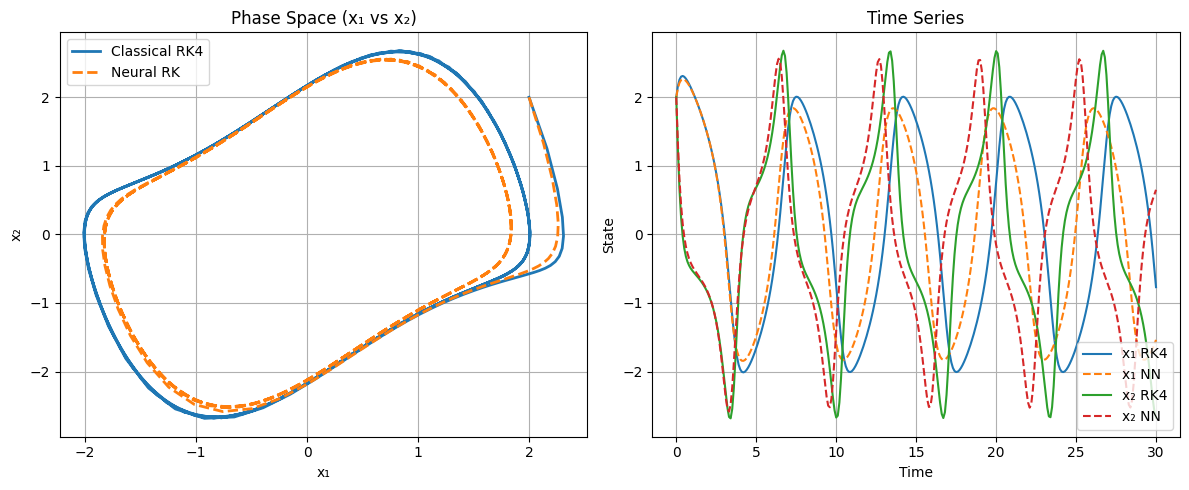

In [237]:
# === Parameters ===
steps = N
x0 = torch.tensor([2,2], dtype=torch.float32).to(device)

# === Rollouts ===
traj_nn = rollout_neural_model(model, x0, steps, dt)
traj_rk = rollout_rk4(x0, steps, dt, 10, rk4, vdp)

# === Plot ===
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(traj_rk[:, 0], traj_rk[:, 1], label="Classical RK4", lw=2)
plt.plot(traj_nn[:, 0], traj_nn[:, 1], '--', label="Neural RK", lw=2)
plt.title("Phase Space (x₁ vs x₂)")
plt.xlabel("x₁")
plt.ylabel("x₂")
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
t = torch.arange(steps + 1) * dt
plt.plot(t, traj_rk[:, 0], label="x₁ RK4")
plt.plot(t, traj_nn[:, 0], '--', label="x₁ NN")
plt.plot(t, traj_rk[:, 1], label="x₂ RK4")
plt.plot(t, traj_nn[:, 1], '--', label="x₂ NN")
plt.title("Time Series")
plt.xlabel("Time")
plt.ylabel("State")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [238]:
# Generate multiple initial conditions
n_ic = 20
x0_set = torch.stack([
    torch.tensor([torch.rand(1).item() * 4 - 2, torch.rand(1).item() * 4 - 2])
    for _ in range(n_ic)
])

# Compute errors
errors = evaluate_final_error(
    model=model,
    rk_func=rk_apply,
    butcher=rk4,
    f=vdp,
    x0_set=x0_set,
    t_end=dt,
    dt=0.1
)

# Report
print("Mean final-time error:", errors.mean().item())
print("Max final-time error: ", errors.max().item())


Mean final-time error: 0.05999244004487991
Max final-time error:  0.42622533440589905


## Comparing Architectures

In [239]:
# === Configurations ===
hidden_dims = [i for i in [1,2,4,8,16,32,64,128]]  # hidden dimensions
num_layers_list = [1,2,3,4,5]
repeats = 1  # optional repeat per config


dt = 0.1
steps = N
device = "cuda" if torch.cuda.is_available() else "cpu"

results = []

# Convergence criterion parameters:
max_epochs = 100000         # Maximum training epochs allowed
tol = 1e-6                 # Minimum loss improvement required
patience = 20              # Number of epochs without improvement to wait

x0_eval = sample_initial_conditions(20).to(device)

# === Loop over Configurations ===
for hidden_dim, num_layers in product(hidden_dims, num_layers_list):
    print(f"Training model with hidden_dim={hidden_dim}, num_layers={num_layers}")
    

    # Initialize model and optimizer
    model = NeuralRK(hidden_dim=hidden_dim, num_layers=num_layers, butcher=rk4).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    

  # Training loop with convergence
    min_epochs = 100
    patience = 20
    delta_tol = 1e-6

    best_loss = float('inf')
    wait = 0
    epoch = 0
    max_epochs = 100000  # safety cap

    if not model.does_model_exist("VDP", "RK4"):

        while True:
            idx = torch.randperm(X.size(0))
            x_batch = X[idx[:64]]
            k_batch = K[idx[:64]]

            optimizer.zero_grad()
            loss = model.loss_fn(x_batch, k_batch)
            loss.backward()
            optimizer.step()

            loss_val = loss.item()

            if epoch % 100 == 0:
                print(f"Epoch {epoch:4d}: Loss = {loss_val:.6f}")

            if epoch >= min_epochs:
                if abs(loss_val - best_loss) < delta_tol:
                    wait += 1
                    if wait >= patience:
                        print(f"Converged after {epoch} epochs with loss {loss_val:.6f}")
                        break
                else:
                    wait = 0
                    best_loss = loss_val

            epoch += 1
            if epoch >= max_epochs:
                print("Stopped early: max epochs reached.")
                break
        
        print(f"Converged in {epoch} epochs with best loss {best_loss:.4e}")
        # Save the model
        model.save_model("VDP", "RK4")

Training model with hidden_dim=1, num_layers=1
path: Results\VDP\Models\NeuralRK_VDP_hd1_layers1_dt0.1_RK4.pt
Epoch    0: Loss = 4.004560
Epoch  100: Loss = 2.625560
Epoch  200: Loss = 2.328559
Epoch  300: Loss = 2.526577
Epoch  400: Loss = 2.216915
Epoch  500: Loss = 2.734526
Epoch  600: Loss = 2.642024
Epoch  700: Loss = 2.162610
Epoch  800: Loss = 1.633649
Epoch  900: Loss = 2.067031
Epoch 1000: Loss = 2.456861
Epoch 1100: Loss = 1.850566
Epoch 1200: Loss = 1.976811
Epoch 1300: Loss = 1.755537
Epoch 1400: Loss = 1.701905
Epoch 1500: Loss = 1.459639
Epoch 1600: Loss = 1.661602
Epoch 1700: Loss = 1.231886
Epoch 1800: Loss = 1.931462
Epoch 1900: Loss = 1.698997
Epoch 2000: Loss = 1.954005
Epoch 2100: Loss = 2.240242
Epoch 2200: Loss = 1.536954
Epoch 2300: Loss = 1.794263
Epoch 2400: Loss = 1.545076
Epoch 2500: Loss = 1.618142
Epoch 2600: Loss = 1.551692
Epoch 2700: Loss = 1.791034
Epoch 2800: Loss = 2.049145
Epoch 2900: Loss = 1.580745
Epoch 3000: Loss = 1.813697
Epoch 3100: Loss = 1.4

In [271]:
# Function to time the rollout of a model
def time_rollout(model, x0, steps, dt):
    start_time = time.time()
    rollout_neural_model(model, x0, steps, dt)
    return time.time() - start_time


### Time and evaluate all saved models
def evaluate_and_time_saved_models(steps,m):
    results = []
    model_dir = r"C:\Users\GeorgeWilliam\Documents\GitHub\TrackExtrapolation\RK_PINNs\Results\VDP\Models"

    for filename in os.listdir(model_dir):
        if filename.endswith(".pt"):
            model_path = os.path.join(model_dir, filename)
            try:
                checkpoint = torch.load(model_path, map_location=device)
                info = checkpoint.get("model_info", {})

                # Extract parameters from checkpoint
                input_dim = info.get("input_dim", 2)
                hidden_dim = info.get("hidden_dim", 64)
                output_dim = info.get("output_dim", 2)
                num_layers = info.get("num_layers", 3)
                dt_val = info.get("dt", 0.1)

                # Construct model with correct architecture
                model = NeuralRK(
                    input_dim=input_dim,
                    hidden_dim=hidden_dim,
                    num_layers=num_layers,
                    output_dim=output_dim,
                    butcher=rk4
                ).to(device)
                model.dt = dt_val
                model.load_state_dict(checkpoint["model_state_dict"])

                # Time the rollout
                rollout_time = time_rollout(model, x0, steps, dt_val)

                # Evaluate final error
                errors = evaluate_final_error(
                    model=model,
                    m=m,
                    butcher=rk4,
                    f=vdp,
                    x0_set=x0_eval,
                    t_end=dt_val,
                    dt=dt_val
                )

                results.append({
                    "model": filename,
                    "mean_error": errors.mean().item(),
                    "max_error": errors.max().item(),
                    "rollout_time": rollout_time
                })

            except Exception as e:
                print(f"❌ Failed to evaluate {filename}: {e}")

    if results:
        df = pd.DataFrame(results)
        df['hidden_dim'] = df['model'].apply(lambda x: int(x.split('_hd')[1].split('_')[0]))
        df['num_layers'] = df['model'].apply(lambda x: int(x.split('_layers')[1].split('_')[0]))
        df['dt'] = df['model'].apply(lambda x: float(x.split('_dt')[1].split('_')[0]))
        df.to_csv("rk_nn_saved_models_evaluation_with_timing.csv", index=False)
        print("\n✅ Saved evaluation and timing to rk_nn_saved_models_evaluation_with_timing.csv")
        return df
    else:
        print("\n⚠️ No models were successfully evaluated.")

evaluate_and_time_saved_models(steps = 1,m = M)





✅ Saved evaluation and timing to rk_nn_saved_models_evaluation_with_timing.csv


,model,mean_error,max_error,rollout_time,hidden_dim,num_layers,dt
0,NeuralRK_VDP_hd128_layers1_dt0.1_RK4.pt,0.024534,0.151385,0.002000,128,1,0.1
1,NeuralRK_VDP_hd128_layers2_dt0.1_RK4.pt,0.025943,0.143622,0.001000,128,2,0.1
2,NeuralRK_VDP_hd128_layers3_dt0.1_RK4.pt,0.026400,0.146815,0.000000,128,3,0.1
3,NeuralRK_VDP_hd128_layers4_dt0.1_RK4.pt,0.027316,0.160144,0.000998,128,4,0.1
4,NeuralRK_VDP_hd128_layers5_dt0.1_RK4.pt,0.024732,0.148312,0.001003,128,5,0.1
5,NeuralRK_VDP_hd16_layers1_dt0.1_RK4.pt,0.030520,0.128573,0.001003,16,1,0.1
6,NeuralRK_VDP_hd16_layers2_dt0.1_RK4.pt,0.024983,0.142066,0.000000,16,2,0.1
7,NeuralRK_VDP_hd16_layers3_dt0.1_RK4.pt,0.024116,0.152902,0.001003,16,3,0.1
8,NeuralRK_VDP_hd16_layers4_dt0.1_RK4.pt,0.025390,0.142900,0.001001,16,4,0.1
9,NeuralRK_VDP_hd16_layers5_dt0.1_RK4.pt,0.023735,0.146709,0.001006,16,5,0.1


C:\Users\GeorgeWilliam\AppData\Local\Temp\ipykernel_5972\545382790.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\GeorgeWilliam\AppData\Local\Temp\ipykernel_5972\545382790.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



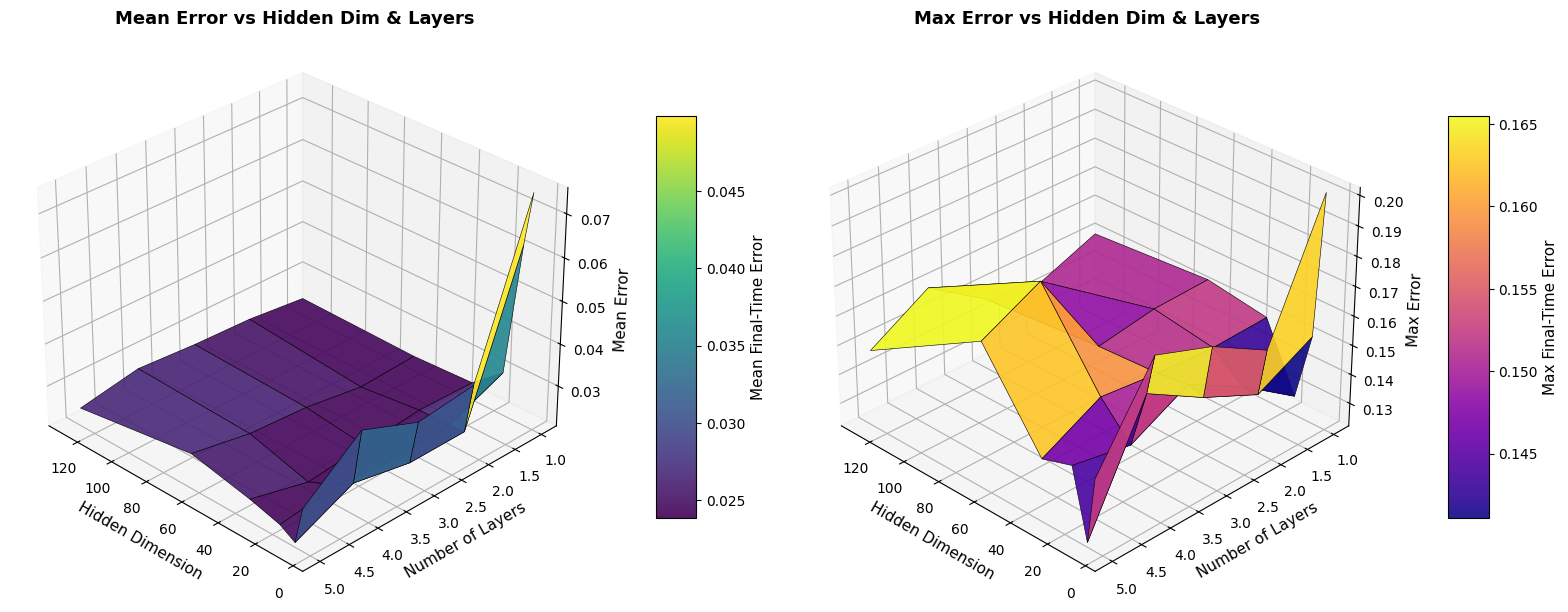

In [272]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D

def plot_mean_and_max_errors_separately(df):
    # Extract model parameters from filename
    df['hidden_dim'] = df['model'].str.extract(r'hd(\d+)').astype(float)
    df['num_layers'] = df['model'].str.extract(r'layers(\d+)').astype(float)

    hidden_dims = sorted(df['hidden_dim'].unique())
    num_layers = sorted(df['num_layers'].unique())
    X, Y = np.meshgrid(hidden_dims, num_layers)

    # Pivot error metrics
    Z_mean = df.pivot_table(index='num_layers', columns='hidden_dim', values='mean_error').values
    Z_max  = df.pivot_table(index='num_layers', columns='hidden_dim', values='max_error').values

    fig = plt.figure(figsize=(16, 7))

    # --- Mean Error Plot ---
    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    surf1 = ax1.plot_surface(X, Y, Z_mean, cmap='viridis', edgecolor='k', linewidth=0.4, alpha=0.9)
    fig.colorbar(surf1, ax=ax1, shrink=0.6, aspect=10, pad=0.1).set_label("Mean Final-Time Error", fontsize=11)

    ax1.set_title("Mean Error vs Hidden Dim & Layers", fontsize=13, weight='bold')
    ax1.set_xlabel("Hidden Dimension", fontsize=11)
    ax1.set_ylabel("Number of Layers", fontsize=11)
    ax1.set_zlabel("Mean Error", fontsize=11)
    ax1.view_init(elev=30, azim=135)
    ax1.grid(True)

    # --- Max Error Plot ---
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    surf2 = ax2.plot_surface(X, Y, Z_max, cmap='plasma', edgecolor='k', linewidth=0.4, alpha=0.9)
    fig.colorbar(surf2, ax=ax2, shrink=0.6, aspect=10, pad=0.1).set_label("Max Final-Time Error", fontsize=11)

    ax2.set_title("Max Error vs Hidden Dim & Layers", fontsize=13, weight='bold')
    ax2.set_xlabel("Hidden Dimension", fontsize=11)
    ax2.set_ylabel("Number of Layers", fontsize=11)
    ax2.set_zlabel("Max Error", fontsize=11)
    ax2.view_init(elev=30, azim=135)
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

df = pd.read_csv("rk_nn_saved_models_evaluation_with_timing.csv")
plot_mean_and_max_errors_separately(df[df['mean_error'] < 0.1])  # Filter for better visibility

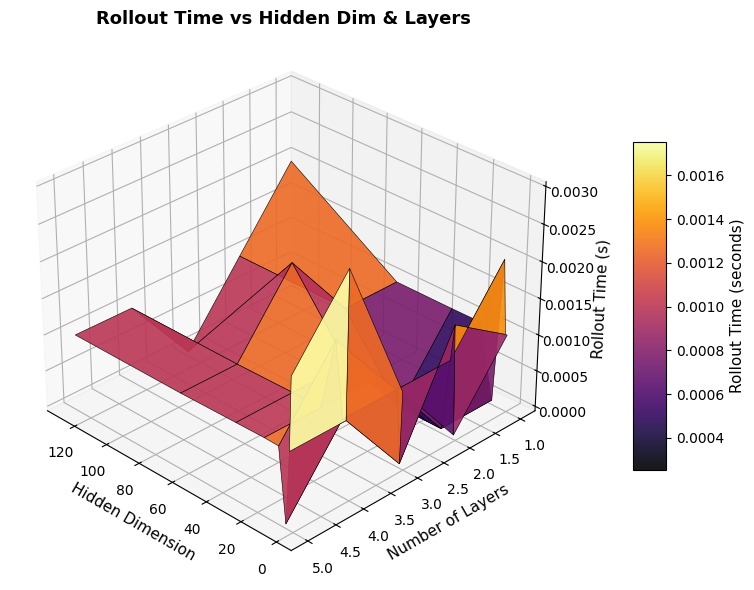

c:\Users\GeorgeWilliam\.conda\envs\TE\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



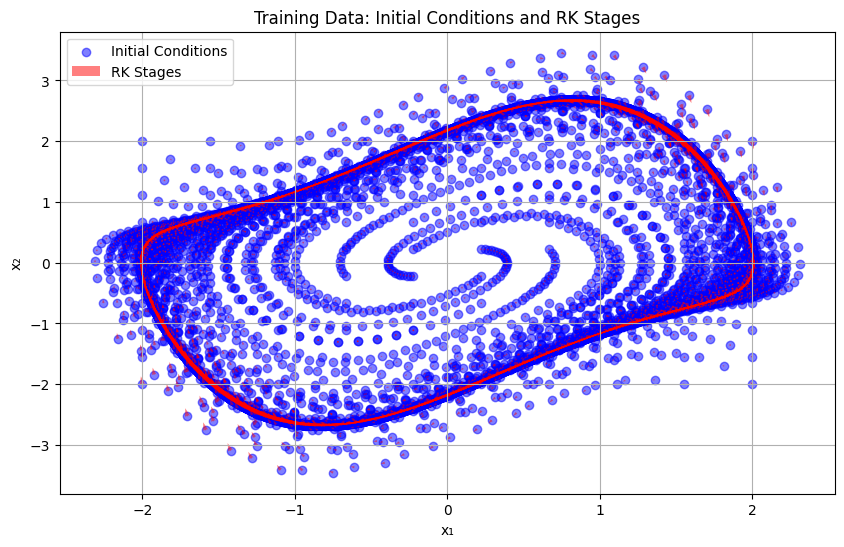

In [273]:
# Plot time vs hidden_dim and num_layers
def plot_rollout_time(df):
    # Extract model parameters from filename
    df['hidden_dim'] = df['model'].str.extract(r'hd(\d+)').astype(float)
    df['num_layers'] = df['model'].str.extract(r'layers(\d+)').astype(float)

    hidden_dims = sorted(df['hidden_dim'].unique())
    num_layers = sorted(df['num_layers'].unique())
    X, Y = np.meshgrid(hidden_dims, num_layers)

    # Pivot rollout time
    Z_time = df.pivot_table(index='num_layers', columns='hidden_dim', values='rollout_time').values

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X, Y, Z_time, cmap='inferno', edgecolor='k', linewidth=0.4, alpha=0.9)
    
    fig.colorbar(surf, ax=ax, shrink=0.6, aspect=10, pad=0.1).set_label("Rollout Time (seconds)", fontsize=11)

    ax.set_title("Rollout Time vs Hidden Dim & Layers", fontsize=13, weight='bold')
    ax.set_xlabel("Hidden Dimension", fontsize=11)
    ax.set_ylabel("Number of Layers", fontsize=11)
    ax.set_zlabel("Rollout Time (s)", fontsize=11)
    ax.view_init(elev=30, azim=135)
    ax.grid(True)

    plt.tight_layout()
    plt.show()

df = pd.read_csv("rk_nn_saved_models_evaluation_with_timing.csv")
plot_rollout_time(df)

# === Plotting the training data ===
def plot_training_data(X, K):
    plt.figure(figsize=(10, 6))
    plt.scatter(X[:, 0].cpu(), X[:, 1].cpu(), c='blue', label='Initial Conditions', alpha=0.5)
    plt.quiver(X[:, 0].cpu(), X[:, 1].cpu(), K[:, :, 0].cpu().mean(dim=1), K[:, :, 1].cpu().mean(dim=1), 
               color='red', label='RK Stages', alpha=0.5)
    plt.title("Training Data: Initial Conditions and RK Stages")
    plt.xlabel("x₁")
    plt.ylabel("x₂")
    plt.legend()
    plt.grid(True)
    plt.show()


plot_training_data(X, K)



✅ Saved evaluation and timing to rk_nn_saved_models_evaluation_with_timing.csv
Evaluating RK4 with M = 1
Evaluating RK4 with M = 2
Evaluating RK4 with M = 3
Evaluating RK4 with M = 4
Evaluating RK4 with M = 5
Evaluating RK4 with M = 6
Evaluating RK4 with M = 7
Evaluating RK4 with M = 8
Evaluating RK4 with M = 9
Evaluating RK4 with M = 10


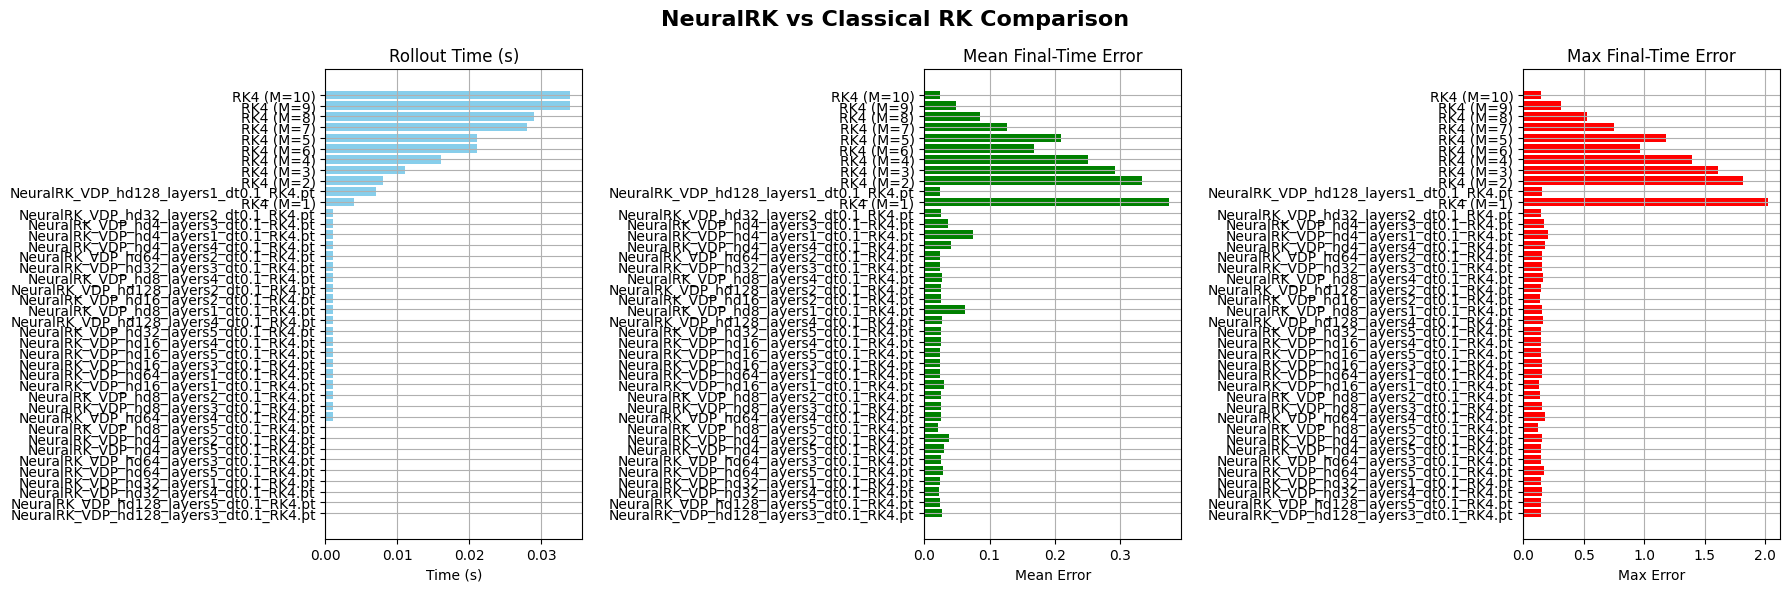

In [276]:
import matplotlib.pyplot as plt
import pandas as pd
import time

def rk_timmer(steps,m, Ms):
    """
    Time the rollout of RK4 for different values of M.

    Args:
        steps (int): Number of steps to roll out.
        Ms (list): List of M values to test.

    Returns:
        pd.DataFrame: Results with rollout time and errors.
    """
    records = []
    for m in Ms:
        print(f"Evaluating RK4 with M = {m}")

        # Time the rollout
        start_time = time.time()
        traj_rk = rollout_rk4(x0, steps, dt, m, rk4, vdp)
        rollout_time = time.time() - start_time

        # Compute final error
        errors = evaluate_final_error(
            model=model,  # this is assumed to be used only for error computation
            m=m,
            butcher=rk4,
            f=vdp,
            x0_set=x0_eval,
            t_end=dt,
            dt=dt
        )

        records.append({
            "method": f"RK4 (M={m})",
            "mean_error": errors.mean().item(),
            "max_error": errors.max().item(),
            "rollout_time": rollout_time
        })
    return pd.DataFrame(records)

def plot_accuracy_and_timing_comparison(df_nn, df_rk):
    """
    Plot rollout time, mean error, and max error for NeuralRK and RK models.
    """
    df_nn_plot = df_nn[["model", "mean_error", "max_error", "rollout_time"]].copy()
    df_nn_plot.rename(columns={"model": "method"}, inplace=True)
    df_nn_plot["source"] = "NeuralRK"

    df_rk["source"] = "RK"

    df_combined = pd.concat([df_nn_plot, df_rk], ignore_index=True)
    df_combined.sort_values(by="rollout_time", inplace=True)

    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    axs[0].barh(df_combined["method"], df_combined["rollout_time"], color="skyblue")
    axs[0].set_title("Rollout Time (s)")
    axs[0].set_xlabel("Time (s)")
    axs[0].grid(True)

    axs[1].barh(df_combined["method"], df_combined["mean_error"], color="green")
    axs[1].set_title("Mean Final-Time Error")
    axs[1].set_xlabel("Mean Error")
    axs[1].grid(True)

    axs[2].barh(df_combined["method"], df_combined["max_error"], color="red")
    axs[2].set_title("Max Final-Time Error")
    axs[2].set_xlabel("Max Error")
    axs[2].grid(True)

    fig.suptitle("NeuralRK vs Classical RK Comparison", fontsize=16, weight='bold')
    plt.tight_layout()
    plt.show()

# === Run evaluation ===
df_nn = evaluate_and_time_saved_models(steps=1,m=10)
df_rk = rk_timmer(steps=1,m = 10, Ms=[i for i in range(1, 11)])

# === Plot results ===
plot_accuracy_and_timing_comparison(df_nn[df_nn['mean_error'] < 0.1], df_rk)


In [244]:
df_nn

,model,mean_error,max_error,rollout_time,hidden_dim,num_layers,dt
0,NeuralRK_VDP_hd128_layers1_dt0.1_RK4.pt,0.024534,0.151385,0.002000,128,1,0.1
1,NeuralRK_VDP_hd128_layers2_dt0.1_RK4.pt,0.025943,0.143622,0.000000,128,2,0.1
2,NeuralRK_VDP_hd128_layers3_dt0.1_RK4.pt,0.026400,0.146815,0.000000,128,3,0.1
3,NeuralRK_VDP_hd128_layers4_dt0.1_RK4.pt,0.027316,0.160144,0.000999,128,4,0.1
4,NeuralRK_VDP_hd128_layers5_dt0.1_RK4.pt,0.024732,0.148312,0.001004,128,5,0.1
5,NeuralRK_VDP_hd16_layers1_dt0.1_RK4.pt,0.030520,0.128573,0.000999,16,1,0.1
6,NeuralRK_VDP_hd16_layers2_dt0.1_RK4.pt,0.024983,0.142066,0.000992,16,2,0.1
7,NeuralRK_VDP_hd16_layers3_dt0.1_RK4.pt,0.024116,0.152902,0.000994,16,3,0.1
8,NeuralRK_VDP_hd16_layers4_dt0.1_RK4.pt,0.025390,0.142900,0.001000,16,4,0.1
9,NeuralRK_VDP_hd16_layers5_dt0.1_RK4.pt,0.023735,0.146709,0.001000,16,5,0.1


In [245]:
df_rk

,method,mean_error,max_error,rollout_time,source
0,RK4 (M=1),0.024732,0.148312,0.004000,RK
1,RK4 (M=2),0.024732,0.148312,0.008000,RK
2,RK4 (M=3),0.024732,0.148312,0.010000,RK
3,RK4 (M=4),0.024732,0.148312,0.012996,RK
4,RK4 (M=5),0.024732,0.148312,0.017992,RK
5,RK4 (M=6),0.024732,0.148312,0.021999,RK
6,RK4 (M=7),0.024732,0.148312,0.024911,RK
7,RK4 (M=8),0.024732,0.148312,0.028999,RK
8,RK4 (M=9),0.024732,0.148312,0.033000,RK
9,RK4 (M=10),0.024732,0.148312,0.040002,RK


## dt analysis

In [246]:
# # === Define the best model from above ===
# def build_best_model():
#     return NeuralRK(hidden_dim=best_hidden, num_layers=best_layers, butcher=rk4).to(device)

# X, K = X_loaded.to(device), K_loaded.to(device)
# # === dt sweep setup ===
# dt_values = [0.01, 0.02, 0.05, 0.1, 0.2, 0.3]
# errors_vs_dt = []

# # === Evaluation initial conditions (same for all dts) ===
# x0_eval = sample_initial_conditions(20).to(device)
# X_loaded, K_loaded = torch.load("Data/VDP/VDP_Training.pt")

# X, K = X_loaded.to(device), K_loaded.to(device)

# # === Train once per dt and evaluate ===
# for dt in dt_values:
#     print(f"Training model for dt = {dt:.3f}")

#     # Build and train model
#     model = NeuralRK(hidden_dim=best_hidden, num_layers=best_layers, butcher=rk4).to(device)
#     optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    
#     # Training loop with convergence
#     min_epochs = 100
#     patience = 20
#     delta_tol = 1e-6

#     best_loss = float('inf')
#     wait = 0
#     epoch = 0
#     max_epochs = 100000  # safety cap

#     while True:
#         idx = torch.randperm(X.size(0))
#         x_batch = X[idx[:64]]
#         k_batch = K[idx[:64]]

#         optimizer.zero_grad()
#         loss = model.loss_fn(x_batch, k_batch)
#         loss.backward()
#         optimizer.step()

#         loss_val = loss.item()

#         if epoch % 100 == 0:
#             print(f"Epoch {epoch:4d}: Loss = {loss_val:.6f}")

#         if epoch >= min_epochs:
#             if abs(loss_val - best_loss) < delta_tol:
#                 wait += 1
#                 if wait >= patience:
#                     print(f"Converged after {epoch} epochs with loss {loss_val:.6f}")
#                     break
#             else:
#                 wait = 0
#                 best_loss = loss_val

#         epoch += 1
#         if epoch >= max_epochs:
#             print("Stopped early: max epochs reached.")
#             break
    
#     print(f"Converged in {epoch} epochs with best loss {best_loss:.4e}")
#     # Save the model
#     model.save_model("VDP", "RK4")

#     # Evaluate error at t_end
#     errors = evaluate_final_error(
#         model=model,
#         rk_func=rk_apply,
#         butcher=rk4,
#         f=vdp,
#         x0_set=x0_eval,
#         t_end=dt,
#         dt=dt
#     )

#     errors_vs_dt.append({
#         "dt": dt,
#         "mean_error": errors.mean().item(),
#         "max_error": errors.max().item()
#     })

# # === Convert to DataFrame & Plot ===
# dt_df = pd.DataFrame(errors_vs_dt)
# dt_df.to_csv("dt_vs_error.csv", index=False)
# print("\nSaved results to dt_vs_error.csv")

# plt.figure(figsize=(8, 5))
# plt.plot(dt_df['dt'], dt_df['mean_error'], 'o-', label='Mean Error')
# plt.plot(dt_df['dt'], dt_df['max_error'], 's--', label='Max Error')
# plt.xlabel("Time Step (dt)")
# plt.ylabel("Final-Time Error")
# plt.title("Final-Time Error vs Time Step")
# plt.grid(True)
# plt.legend()
# plt.show()





## Variable delta t